In [1]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [2]:
import os
import csv
import random
import numpy as np
from PIL import Image as PIL_Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.utils.data as data
from torch.optim.lr_scheduler import StepLR, CosineAnnealingLR
from torch.autograd import Variable

from torchvision import transforms
from torchvision.models import resnet50, resnet152

# 랜덤 시드 고정

In [7]:
seed = 400

os.environ['PYTHONHASHSEED'] = str(seed)
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)    
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

In [8]:
drivepath = "/content/gdrive/MyDrive"

In [9]:
device_type = "cuda" if torch.cuda.is_available() else "cpu"
device = torch.device(device_type)
print(device)

cuda


# 모델과 그에 맞는 데이터셋 설정

Convolution layer의 출력을 FC layer에 통과시킨 뒤 매 타임스탭마다 이미지를 입력받아 키 입력을 출력하는 다대다 lstm 모델을 구성합니다.

In [10]:
class KartModel8(nn.Module):
  def __init__(self, num_class = 64, cnn_to_lstm = 1024, lstm_hidden = 512, num_layers = 5):
    super(KartModel8, self).__init__()
    self.num_class = num_class
    self.num_layers = num_layers
    self.hidden_size = lstm_hidden

    self.resnet = resnet50(pretrained=True)
    self.resnet.fc = nn.Sequential(
      nn.Linear(in_features=2048, out_features=cnn_to_lstm, bias=True),
      nn.ReLU(),
    )
    self.lstm_image = nn.LSTM(
        input_size = cnn_to_lstm,
        hidden_size = lstm_hidden,
        num_layers = num_layers,
        batch_first = True,
        dropout = 0.3,
    )
    self.lstm_key = nn.LSTM(
        input_size = 6,
        hidden_size = lstm_hidden,
        num_layers = num_layers,
        batch_first = True,
        dropout = 0.3,
    )

    self.fc_1 = nn.Linear(lstm_hidden * 2, lstm_hidden * 2)
    self.bn1 = nn.BatchNorm1d(lstm_hidden * 2)
    self.relu = nn.ReLU()
    self.fc_2 = nn.Linear(lstm_hidden * 2, lstm_hidden)
    self.bn2 = nn.BatchNorm1d(lstm_hidden)
    self.fc_3 = nn.Linear(lstm_hidden, num_class)
    # self.sigmoid = nn.Sigmoid()

  def forward(self, x_3d, key_inputs, hidden1 = None, hidden2 = None):
    for t in range(x_3d.size(1)):
      with torch.no_grad():
        x = self.resnet(x_3d[:, t, :, :, :])
        out1, hidden1 = self.lstm_image(x.unsqueeze(1), hidden1)
    # batch first = True
    # batch, seq, hidden_size

    out2, hidden2 = self.lstm_key(key_inputs, hidden2)

    out = self.fc_1(torch.cat([out1[:, -1, :], out2[:, -1, :]], dim=1))
    # 마지막 sequence
    out = self.bn1(out)
    out = self.relu(out)
    out = self.fc_2(out)
    out = self.bn2(out)
    out = self.relu(out)
    out = self.fc_3(out)
    # out = self.sigmoid(out)

    return out, hidden1, hidden2

In [13]:
seq_size = 10

In [14]:
class KartDataSet8(data.Dataset):
  def __init__(self, csv_files):
    self.image_seqs = []
    self.label_seqs = []

    for csv_file in csv_files:
      images = []
      labels = []

      with open(csv_file) as csvfile:
        csv_reader = csv.reader(csvfile)
        next(csv_reader, None)        # 첫번째 row 스킵
        
        for row in csv_reader:
          images.append(drivepath + '/' + row[0])
          labels.append([int(x) for x in list(row[1])])

      for i in range(len(images)):
        if i - seq_size >= 0:
          self.image_seqs.append(images[i - seq_size + 1:i + 1])
          # 하나 적게
          self.label_seqs.append(labels[i - seq_size:i + 1])

  def __getitem__(self, index):
    # cur_seq_size = random.randint(1, seq_size)
    cur_seq_size=20
    image_paths = self.image_seqs[index][:cur_seq_size]
    images = [PIL_Image.open(image_path) for image_path in image_paths]
    labels = self.label_seqs[index][:cur_seq_size + 1]
    label = int(''.join(map(str, labels[-1])), 2)

    image_pads = [torch.rand(3, 224, 224) for _ in range(seq_size - cur_seq_size)]
    label_pads = [[random.randint(0, 1) for _ in range(6)] for _ in range(seq_size - cur_seq_size)]

    preprocess = transforms.Compose([
      transforms.Resize((224, 224)),
      transforms.ToTensor(),
      # transforms.Grayscale(num_output_channels=3),
      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),     # -1 ~ 1 로 normalize
    ])

    preprocessed_list = []
    for img in images:
      preprocessed_list.append(preprocess(img))

    # print(label_pads + labels[:-1])
    
    return torch.stack(image_pads + preprocessed_list), torch.Tensor(label_pads + labels[:-1]), label

  def __len__(self):
    return len(self.image_seqs)

In [15]:
csvs = [f"{drivepath}/csv/kart_test_minimap_test_{str(i)}.csv" for i in range(5)]
# csvs = [f"{drivepath}/csv/kart_test_minimap2.csv"]
dataset = KartDataSet8(csvs)
# x = dataset[1]
# print(x[0].shape)
# print(x[1].shape)
print((dataset[0][0]).shape)
print((dataset[0][1]).shape)
print((dataset[99][2]))
# seq, channel, width, height
# label

torch.Size([10, 3, 224, 224])
torch.Size([10, 6])
48


# 하이퍼 파라미터 설정

In [16]:
num_epochs = 10
lr = 1e-4
batch_size = 8
log_interval = 10

In [17]:
loader = data.DataLoader(
    dataset,
    batch_size=batch_size,
    num_workers=4,
    shuffle=True,
    drop_last=True,
)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [18]:
print(len(loader))
print(len(dataset))

659
5275


# 모델 저장 설정 및 학습 가능한 레이어 확인

In [19]:
save_path = drivepath + "/test_model_minimap5.pt"

model = KartModel8()
# model.load_state_dict(torch.load(save_path))
model = model.to(device)

for param, weight in model.named_parameters():
    print(f"param {param:20} required gradient? -> {weight.requires_grad}")
# model = model.to(device)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth



param resnet.conv1.weight  required gradient? -> True
param resnet.bn1.weight    required gradient? -> True
param resnet.bn1.bias      required gradient? -> True
param resnet.layer1.0.conv1.weight required gradient? -> True
param resnet.layer1.0.bn1.weight required gradient? -> True
param resnet.layer1.0.bn1.bias required gradient? -> True
param resnet.layer1.0.conv2.weight required gradient? -> True
param resnet.layer1.0.bn2.weight required gradient? -> True
param resnet.layer1.0.bn2.bias required gradient? -> True
param resnet.layer1.0.conv3.weight required gradient? -> True
param resnet.layer1.0.bn3.weight required gradient? -> True
param resnet.layer1.0.bn3.bias required gradient? -> True
param resnet.layer1.0.downsample.0.weight required gradient? -> True
param resnet.layer1.0.downsample.1.weight required gradient? -> True
param resnet.layer1.0.downsample.1.bias required gradient? -> True
param resnet.layer1.1.conv1.weight required gradient? -> True
param resnet.layer1.1.bn1.weig

# Loss, Optimizer, Scheduler 설정

In [20]:
criterion = nn.CrossEntropyLoss()
# pos_weight = torch.Tensor([5/95, 70/30, 70/30, 95/5, 85/15, 1.0])
# pos_weight = pos_weight.to(device)
# criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
# criterion = nn.BCEWithLogitsLoss()
# criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=5e-4)
# scheduler = StepLR(optimizer, 5, gamma=0.5)
scheduler = CosineAnnealingLR(optimizer, T_max=50)

In [21]:
it = iter(loader)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [22]:
inputs, key_inputs, labels = next(it)
print(inputs.shape)
print(key_inputs.shape)
print(labels)
# batch, seq, channel, width, height
# batch, seq, label

torch.Size([8, 10, 3, 224, 224])
torch.Size([8, 10, 6])
tensor([32, 32, 48, 40, 48, 32, 32, 42])


# 데이터로더, 모델 인풋, 아웃풋 점검

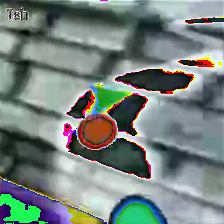

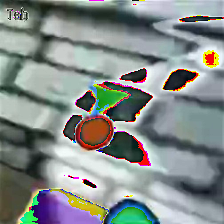

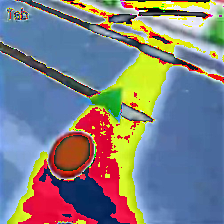

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


tensor([19, 57, 49, 26, 23, 18,  4, 36], device='cuda:0')
tensor([32, 32, 48, 40, 48, 32, 32, 42], device='cuda:0')
0
tensor(4.3512, grad_fn=<CopyBackwards>)


In [23]:
from torchvision.transforms import ToPILImage
from IPython.display import Image
to_img = ToPILImage()
sigmoid = nn.Sigmoid()

display(to_img(inputs[0][0]))
display(to_img(inputs[0][1]))
display(to_img(inputs[0][-1]))

inputs = inputs.to(device)
key_inputs = key_inputs.to(device)
labels = labels.to(device)
outs, _, _ = model(inputs, key_inputs)
preds = torch.argmax(outs, dim=-1)
print(preds)
print(labels)
matches = (labels == preds).sum().item()
print(matches)
# print(((outs > 0.5) == labels).sum(axis=1))
# print((((outs > 0.5) == labels).sum(axis=1) == 6).sum())
loss = criterion(outs, labels)
# print(labels)
print(loss.cpu())
# print(((labels == (outs > 0.5)).sum(axis=2) == 6).sum())
# print(outs > 0.5)
# print(labels)

# 학습 진행상황 확인을 위한 wandb 설정

In [24]:
!pip install wandb

     |████████████████████████████████| 1.8MB 8.2MB/s 
     |████████████████████████████████| 143kB 52.6MB/s 
     |████████████████████████████████| 174kB 51.4MB/s 
     |████████████████████████████████| 102kB 15.9MB/s 
     |████████████████████████████████| 71kB 11.7MB/s 
  Created wheel for subprocess32: filename=subprocess32-3.5.4-cp37-none-any.whl size=6502 sha256=d5d616f7107c19e4db5726599a639e32843eb9dd665fecb8a4d3bfe10da9c45c
  Stored in directory: /root/.cache/pip/wheels/68/39/1a/5e402bdfdf004af1786c8b853fd92f8c4a04f22aad179654d1
  Created wheel for pathtools: filename=pathtools-0.1.2-cp37-none-any.whl size=8807 sha256=177a2e8c2807834dcf51c99725ce918bef4c554c9d14ad332a54d8122c7b6ea7
  Stored in directory: /root/.cache/pip/wheels/0b/04/79/c3b0c3a0266a3cb4376da31e5bfe8bba0c489246968a68e843
Successfully built subprocess32 pathtools


In [25]:
import wandb

wandb.login()

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [26]:
config = {}
config['n_epochs'] = num_epochs
config['batch_sze'] = batch_size
# config['lr'] = lr


wandb.init(project="boomhill24_6", config=config)

wandb: Currently logged in as: junhyeokk (use `wandb login --relogin` to force relogin)


# 학습 진행 및 저장

In [29]:
for epoch in range(num_epochs):
  model.train()
  loss_value = 0
  matches = 0
  
  for idx, train_batch in enumerate(loader):
    inputs, key_inputs, labels = train_batch
    inputs = inputs.to(device)
    key_inputs = key_inputs.to(device)
    labels = labels.to(device)

    outs, _, _ = model(inputs, key_inputs)
    preds = torch.argmax(outs, dim=-1)
    loss = criterion(outs, labels)

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    loss_value += loss.item()
    # matches += (preds == labels).sum().item()
    # matches += ((preds == labels).sum(axis = 1) == 6).sum()
    matches += (labels == preds).sum().item()

    if (idx + 1) % log_interval == 0:
      train_loss = loss_value / log_interval
      train_acc = matches / batch_size / log_interval
      current_lr = scheduler.get_last_lr()

      wandb.log({"epoch" : epoch, "training_loss" : train_loss, "training_acc" : train_acc, "learning_rate" : current_lr})
      print(
          f"Epoch[{epoch + 1}/{num_epochs}]({idx + 1}/{len(loader)}) || "
          # f"training loss {train_loss:4.4} || lr {current_lr}"
          f"training loss {train_loss:4.4} || training accuracy {train_acc:4.2%} || lr {current_lr}"
      )

      loss_value = 0
      matches = 0

    scheduler.step()
    
  # torch.save(model.state_dict(), save_path)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch[1/10](10/659) || training loss 1.39 || training accuracy 47.50% || lr [9.990133642128417e-05]
Epoch[1/10](20/659) || training loss 1.117 || training accuracy 58.75% || lr [9.221639627498297e-05]
Epoch[1/10](30/659) || training loss 1.432 || training accuracy 46.25% || lr [6.84062276341466e-05]
Epoch[1/10](40/659) || training loss 1.439 || training accuracy 53.75% || lr [3.756550564171113e-05]
Epoch[1/10](50/659) || training loss 1.442 || training accuracy 51.25% || lr [1.1474337861194495e-05]
Epoch[1/10](60/659) || training loss 1.546 || training accuracy 41.25% || lr [9.866357858625546e-08]
Epoch[1/10](70/659) || training loss 1.227 || training accuracy 60.00% || lr [7.783603724908109e-06]
Epoch[1/10](80/659) || training loss 1.381 || training accuracy 51.25% || lr [3.159377236580434e-05]
Epoch[1/10](90/659) || training loss 1.528 || training accuracy 48.75% || lr [6.24344943583162e-05]
Epoch[1/10](100/659) || training loss 1.791 || training accuracy 43.75% || lr [8.852566213889

In [30]:
torch.save(model.state_dict(), save_path)

torch.Size([8, 10, 3, 224, 224])
torch.Size([8, 10, 6])
torch.Size([8])


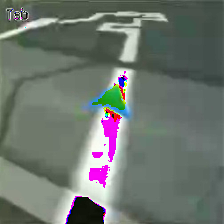

tensor([[-2.5056, -5.6158, -5.7174, -5.6139, -5.6152, -5.6143, -5.6144, -5.6150,
         -3.3639, -5.6145, -5.5239, -6.4117, -5.6138, -5.6145, -5.6145, -5.6164,
         -4.0985, -4.6416, -5.9672, -5.6143, -5.6150, -5.6136, -5.6148, -5.6144,
         -5.6147, -5.6150, -5.6154, -5.6144, -5.6151, -5.6152, -5.6145, -5.6148,
          4.1362, -5.6152, -3.3435, -5.6149,  1.3500, -5.6144, -5.6131, -5.6147,
          3.2447, -5.6137,  0.1790, -5.6157,  0.6512, -5.6157, -3.0530, -5.6134,
          2.9239, -5.6159,  0.2711, -5.6152, -0.7086, -5.6161, -3.8302, -5.6141,
         -1.9466, -5.6172, -4.4456, -5.6141, -5.6147, -5.6148, -8.3556, -5.6149],
        [-3.6654, -6.1975, -5.9397, -6.1994, -6.1982, -6.1990, -6.1989, -6.1982,
         -3.9371, -6.1986, -6.3859, -6.6701, -6.1994, -6.1987, -6.1987, -6.1967,
         -1.9063, -5.7970, -3.2234, -6.1989, -6.1980, -6.1997, -6.1984, -6.1989,
         -6.1985, -6.1980, -6.1979, -6.1989, -6.1982, -6.1979, -6.1986, -6.1983,
          2.9673, -6.1981, 

In [31]:
inputs, key_inputs, labels = next(it)
print(inputs.shape)
print(key_inputs.shape)
print(labels.shape)
# batch, seq, channel, width, height
# batch, seq, label

display(to_img(inputs[0][0]))
# display(to_img(inputs[0][1]))
# display(to_img(inputs[0][-1]))

model.eval()

inputs = inputs.to(device)
key_inputs = key_inputs.to(device)
labels = labels.to(device)
outs, h1, h2 = model(inputs, key_inputs)
print(outs)
preds = torch.argmax(outs, dim=-1)
print(preds)
loss = criterion(outs, labels)
print(labels)
print(loss.cpu())

In [32]:
print(labels)

tensor([48, 48, 32, 48, 40, 40, 48, 40], device='cuda:0')


In [33]:
torch.cuda.empty_cache()

inputs, key_inputs, labels = next(it)

model.eval()

inputs = inputs.to(device)
key_inputs = key_inputs.to(device)
labels = labels.to(device)

outs, h1, h2 = model(inputs, key_inputs)

preds = torch.argmax(outs, dim=-1)
print(preds)
print(labels)

tensor([42, 40, 48, 48, 48, 50, 42, 40], device='cuda:0')
tensor([40, 32, 32, 56, 48, 50, 32, 42], device='cuda:0')


In [34]:
model.eval()

outs, _, _ = model(inputs, key_inputs, h1, h2)

preds = torch.argmax(outs, dim=-1)
print(preds)
print(labels)

tensor([42, 40, 48, 48, 48, 50, 42, 40], device='cuda:0')
tensor([40, 32, 32, 56, 48, 50, 32, 42], device='cuda:0')


In [35]:
model.eval()

outs, _, _ = model(inputs, key_inputs)

preds = torch.argmax(outs, dim=-1)
print(preds)
print(labels)

tensor([42, 40, 48, 48, 48, 50, 42, 40], device='cuda:0')
tensor([40, 32, 32, 56, 48, 50, 32, 42], device='cuda:0')


In [39]:
model.eval()

h1 = None
h2 = None

idx = 100
for i in range(seq_size):
  img = dataset[idx][0][i].unsqueeze(0).unsqueeze(0).to(device)
  key = dataset[idx][1][i].unsqueeze(0).unsqueeze(0).to(device)
  out, h1, h2 = model(img, key, h1, h2)
  pred = torch.argmax(out, dim=-1)
  print(pred.item())
print(f"label : {dataset[idx][2]}")

32
32
32
32
48
48
48
32
32
48
label : 48
